In [1]:
import os
import glob
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm, tqdm_notebook
import tools
%matplotlib notebook

### komentarji:
    
    - omejitev števila točk (urejeno glede na "moč" ujemanja)
    - log napak projekcije
    - boljša triangulacija!
    - unikaten identifier vsake matrike ``[R|t]`` (da niso naslavljane po indeksu)

In [2]:
SCALE = 0.2
MATCH_RATIO = 0.8  # more -> LESS matches rejected
NFEV = 20000         # maximum number of least_squares iterations
MODE = 'ORB'        # feature extraction algorithm

In [3]:
d_max = 1       # (for RANSAC) maximum distance from epipolar line above which a point is considered an outlier
alpha = 0.995   # (RANSAC) desired probability, that the estimated F matrix is correct

In [4]:
path = 'images/dvoriscna'
path_calib = 'kalibracija/redmi'
images = glob.glob(os.path.join(path, '*.JPG'))[1:-1]
calibration_images = glob.glob(os.path.join(path_calib, '*.JPG'))

### main loop

In [5]:
beginning_time = time.perf_counter()

In [6]:
scene = {}
K, distCoeffs = tools.calibrate_camera(calibration_images, (6, 4), (40, 40), scale=0.5)
N = len(images)

In [7]:
after_calibration = time.perf_counter()

In [8]:
plot = False
%matplotlib inline

for i in tqdm_notebook(range(N - 1)):
    
    if i == 0:
        last_Rt = None
        im1 = tools.read_bw(images[i])
        im2 = tools.read_bw(images[i+1])
        Rt1, Rt2, p1, p2 = tools.get_camera_matrices(im1, im2, K, last_Rt, optimize=True, d_max=d_max, alpha=alpha,
                                           scale=SCALE, match_ratio=MATCH_RATIO, mode=MODE)
    else:
        im1 = im2
        im2 = tools.read_bw(images[i+1])
        Rt1, Rt2, p1, p2 = tools.get_camera_matrices_PnP(im1, im2, K, last_Rt, cloud, i, distCoeffs, 
                                            d_max=d_max, alpha=alpha, scale=SCALE, match_ratio=MATCH_RATIO, mode=MODE)

    last_Rt = Rt2
    P1 = K.dot(Rt1)
    P2 = K.dot(Rt2)
    
    points3D = []
    for x1, x2 in zip(p1, p2):
        X = tools.triangulate_lm(tools.to_homogenous(x1), tools.to_homogenous(x2), P1, P2)
        points3D.append(tools.Point3D(X, x1, x2, i, i+1))
    
    if i == 0:
        cloud = tools.Scene([Rt1, Rt2], points3D, K, im1.shape, debug=True)
        #cloud.bundle_adjustment(ftol=1e-8, max_nfev=NFEV, max_sd_dist=2, X_only=True)
    else:
        pair = tools.Scene([Rt1, Rt2], points3D, K, im1.shape, frame_offset=i, debug=True)
        #pair.bundle_adjustment(ftol=1e-8, max_nfev=NFEV, max_sd_dist=2, X_only=False)
        cloud.add_next_pair(pair)
        
#         # Sequential bundle adjustment
#         print('\n--- seqential BA, image pair {:d} ---'.format(i))
#         cloud.bundle_adjustment(ftol=1e-6, max_nfev=NFEV, max_sd_dist=2, X_only=False)
        
    if plot:# and i % (N//2) == 0:
        print('---- slika {:d} ----\n'.format((i+1)))
        cloud.render()
        
        fig, ax = plt.subplots(1, 2, figsize=(10, 3))
        ax[0].imshow(im1, cmap='gray')
        ax[0].scatter(p1[:, 0], p1[:, 1])
        ax[1].imshow(im2, cmap='gray')
        ax[1].scatter(p2[:, 0], p2[:, 1])
        plt.show()

PnPRANSAC  73
PnPRANSAC  41
PnPRANSAC  34
PnPRANSAC  46
PnPRANSAC  60
PnPRANSAC  31



In [9]:
main_loop_time = time.perf_counter()

In [10]:
#X, Y, Z = cloud.render()

Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


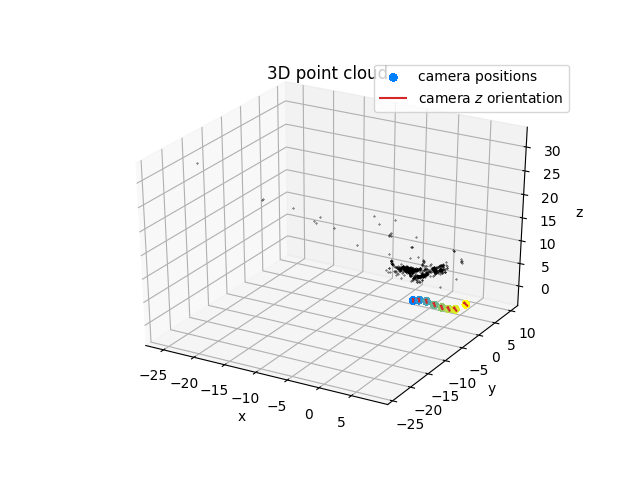

760 identified points (760 shown).


In [11]:
%matplotlib
X, Y, Z = cloud.render(cameras=True)

In [12]:
#cloud.bundle_adjustment(ftol=1e-5, max_nfev=5000)
X, Y, Z = cloud.render(cameras=True, openGL=True)

SystemExit: 0

D:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2889: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
cloud.points3D[list(cloud.points3D.keys())[500]].X

In [ ]:
end_time = time.perf_counter()

In [ ]:
total = end_time - beginning_time 
calibration = after_calibration - beginning_time
loop = main_loop_time - after_calibration
ba = end_time - main_loop_time
print('total time:\t{:.0f} min {:.1f} s'.format(total // 60, total % 60))
print('calib. time:\t{:.0f} min {:.1f} s'.format(loop // 60, calibration % 60))
print('loop time:\t{:.0f} min {:.1f} s'.format(loop // 60, loop % 60))
print('ba time:\t{:.0f} min {:.1f} s'.format(ba // 60, ba % 60))

In [ ]:
name = path.replace('/', '_').replace('\\', 'n')
name += '_sequential_final_BA'
#cloud.pickle_save(name=name, path='results', mode='scene')

In [ ]:
#cloud.render(openGL=True, cameras=True)